In [7]:
import os, sys
import random
import numpy as np
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import time

import tqdm
import h5py

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
VERSION = '03'

try:
    import google.colab
    from google.colab import drive

    drive.mount('/content/gdrive', force_remount=True)
    ROOT_PATH = 'gdrive/My Drive/Colab Notebooks/LANL'
    print('Working on google colab')
except:
    ROOT_PATH = '..'
    print('Working locally')

directory= f'{ROOT_PATH}/models/{VERSION}'
if not os.path.exists(directory):
    os.makedirs(directory)    

Mounted at /content/gdrive
Working on google colab


In [0]:
def progress_bar(current_value, max_value, size=50):
    prog = (current_value+1)/max_value
    left = '#'*int(prog * size + 0.5) # 0.5 to round up when casting to int
    right = '-'*(size-len(left))
    print('\r[{}{}] {:.1f}%'.format(left, right, prog*100), end='')
    
    
def plot_regression(ax, x, y):
       
    nbins=100
    data = np.concatenate([x.reshape(-1, 1),y.reshape(-1, 1)], axis=1)
    k = kde.gaussian_kde(data.T)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Blues)
    ax.plot([0,1], [0, 1], color='k', linewidth=1)
    ax.plot(x, y, '.',  color='k', alpha=0.3)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Ground truth')
    ax.set_ylabel('Model prediction')
    
    return ax

In [0]:
train_data_filename = f'{ROOT_PATH}/data/train_data_sorted.h5'

with h5py.File(train_data_filename, 'r') as f:
    X_train = f['X_train'][()]
    y_train = f['y_train'][()]
    
dev_data_filename = f'{ROOT_PATH}/data/dev_data_sorted.h5'
with h5py.File(dev_data_filename, 'r') as f:
    X_dev = f['X_dev'][()]
    y_dev = f['y_dev'][()]
    


    
# from sklearn.preprocessing import Normalizer
# transformer = Normalizer().fit(X_train)

# X_train = transformer.transform(X_train)
# X_dev = transformer.transform(X_dev)


# y_max = np.max(y_train)
# y_train = y_train/y_max
# y_dev = y_dev/y_max

    
X_train = X_train.reshape(X_train.shape[0], -1, 1)
X_dev = X_dev.reshape(X_dev.shape[0], -1, 1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten
from keras.layers.convolutional import Conv1D, SeparableConv1D
from keras.layers.convolutional import MaxPooling1D, AveragePooling1D
from keras.layers import Dropout
from keras.layers import CuDNNGRU, LSTM
from keras.initializers import glorot_uniform
from keras import regularizers
from keras import optimizers


def create_model():
    seed = 42

    model = Sequential()
    model.add(AveragePooling1D(pool_size=2))
    model.add(SeparableConv1D(filters=8, kernel_size=3, padding='same', activation='relu', ))
    model.add(MaxPooling1D(pool_size=16))
    
    model.add(SeparableConv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=8))
    
    model.add(SeparableConv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(CuDNNGRU(50))

#     model.add(Flatten())
#     model.add(Dropout(rate = 0.4))
 
    model.add(Dense(50, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1))

    return model


In [28]:

from scipy.stats import kde
from keras import optimizers


model = create_model()
model.compile(optimizer=optimizers.Adam(lr=0.002), loss='mean_squared_error')

loss = []
val_loss = []
epoch_index = 0
NUMBER_OF_EPOCHS = 40

for _ in range(NUMBER_OF_EPOCHS):
    fit_out = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_dev, y_dev), verbose=0)
    loss = loss + fit_out.history['loss']
    val_loss = val_loss + fit_out.history['val_loss']

#     y_predict_dev = model.predict(X_dev)
#     y_predict_train = model.predict(X_train)
    
#     fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11, 5))
#     ax1.set_title('Training set')
#     ax1 = plot_regression(ax1, y_train, y_predict_train)
    
#     ax2.set_title('Development set')
#     ax2 = plot_regression(ax2, y_dev, y_predict_dev)

#     save_fig_directory = f'{ROOT_PATH}/plots/evolution_5'
#     if not os.path.exists(save_fig_directory):
#         os.makedirs(save_fig_directory)    
    
#     fig.savefig(f'{save_fig_directory}/model_1_{epoch_index:03d}.png', bbox_inches='tight')
#     plt.close()
 
    
    progress_bar(epoch_index, NUMBER_OF_EPOCHS)
    epoch_index = epoch_index + 1


[##################################################] 100.0%

[Text(0, 0.5, 'loss'), Text(0.5, 0, 'epochs')]

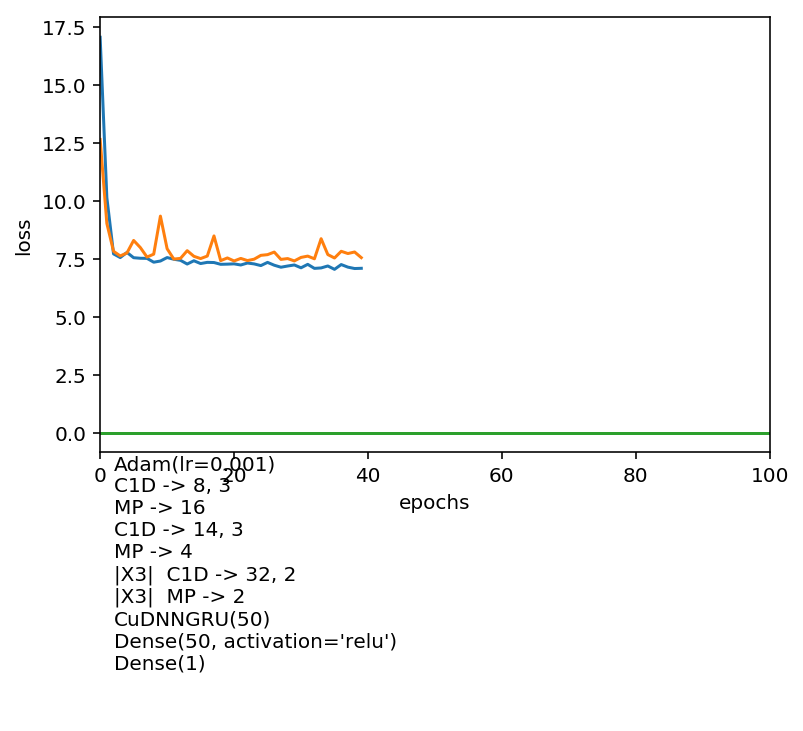

In [29]:
fig, ax = plt.subplots(1, figsize=(6,4))

description='''
Adam(lr=0.001)
C1D -> 8, 3
MP -> 16
C1D -> 14, 3
MP -> 4
|X3|  C1D -> 32, 2
|X3|  MP -> 2 
CuDNNGRU(50)
Dense(50, activation='relu')
Dense(1)

'''

achieved_loss = 0.031
ax.plot(loss)
ax.plot(val_loss)

ax.plot([0,100], [0.034, 0.034], color='gray')

ax.plot([0,100], [achieved_loss, achieved_loss])

# ax.set_ylim(0.0, 0.05)

ax.set_xlim(0,100)
ax.text(x=2, y=achieved_loss, s=description, verticalalignment='top')

ax.set(**{'xlabel':'epochs', 'ylabel':'loss'})

In [0]:


model = create_model()
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [0]:
loss = []
val_loss = []

fit_out = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_dev, y_dev), verbose=1)
loss = loss + fit_out.history['loss']
val_loss = val_loss + fit_out.history['val_loss']

Train on 3342 samples, validate on 836 samples
Epoch 1/20
3342/3342 [==============================] - 3s 752us/step - loss: 0.0526 - val_loss: 0.0504
Epoch 2/20
3342/3342 [==============================] - 2s 734us/step - loss: 0.0501 - val_loss: 0.0493
Epoch 3/20
3342/3342 [==============================] - 2s 741us/step - loss: 0.0469 - val_loss: 0.0436
Epoch 4/20
3342/3342 [==============================] - 2s 737us/step - loss: 0.0425 - val_loss: 0.0395
Epoch 5/20
3342/3342 [==============================] - 2s 740us/step - loss: 0.0403 - val_loss: 0.0383
Epoch 6/20
3342/3342 [==============================] - 2s 738us/step - loss: 0.0392 - val_loss: 0.0373
Epoch 7/20
3342/3342 [==============================] - 2s 738us/step - loss: 0.0383 - val_loss: 0.0365
Epoch 8/20
3342/3342 [==============================] - 3s 757us/step - loss: 0.0368 - val_loss: 0.0586
Epoch 9/20
3342/3342 [==============================] - 3s 751us/step - loss: 0.0388 - val_loss: 0.0397
Epoch 10/20
3342/

(0, 1)

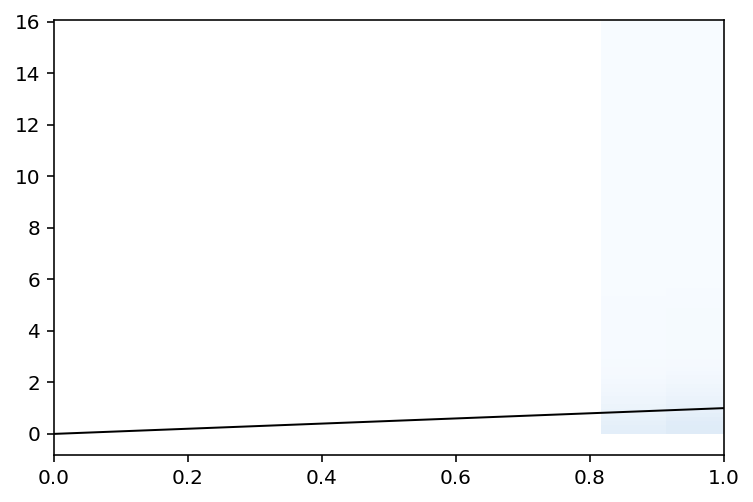

In [30]:
y_predict_dev = model.predict(X_dev)
y_predict_train = model.predict(X_train)
from scipy.stats import kde

x = y_predict_train
y = y_train
nbins=100

data = np.concatenate([x.reshape(-1, 1),y.reshape(-1, 1)], axis=1)
k = kde.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))


plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Blues)
# plt.hexbin(x, y, gridsize=nbins, cmap=plt.cm.BuGn_r)


# plt.plot(y_predict_train, y_train, '.', ms=2, color='black', alpha=0.5)
plt.plot(y_predict_dev, y_dev, 'x', color='k', alpha=0.3)


plt.plot([0,1], [0, 1], color='k', linewidth=1)
plt.xlim(0,1)

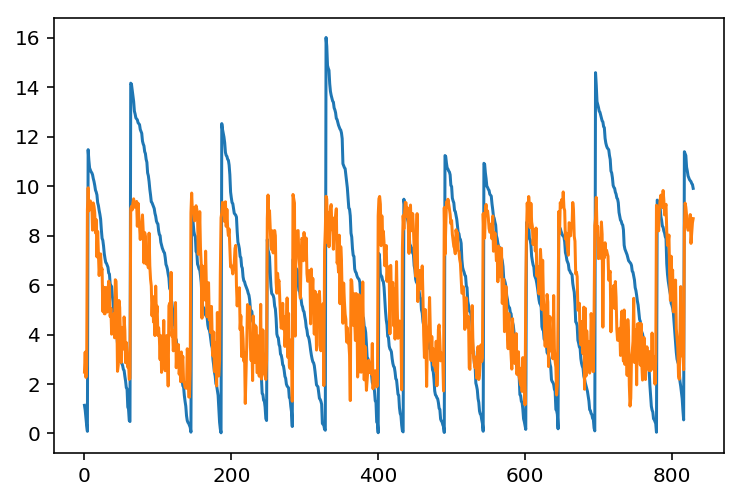

In [31]:
plt.plot(y_dev)
plt.plot(y_predict_dev)
